In [98]:
### test_lgs_params.ipynb
### attempting to pull relevant parameters from science and weather data
### imports
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from astropy.io import fits
import lgs_metadata_compiler as md
import matplotlib.pyplot as plt
### My file
import ML_util as util
### ML algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [99]:
### Files and folders
root_dir = "/g/lu/data/gc/" # root data directory
tables = "/u/steverobinson/work/keckao/" # folder of data tables found in Steve's directory
meta_file = tables+"lgs_metadata2.fits" # test metadata table
# strehl and fwhm are labels, the rest are features
use_cols = ['strehl', 'fwhm', 'airmass', 'az', 'MASS', 'DIMM', 'wind_speed', 
               'wind_direction', 'temperature', 'relative_humidity', 'pressure']
Y_data = use_cols[:2]
# guessing that DIMM is the DIMM seeing, MASS is the MASS seeing
# not really sure what units anything is in

(5949, 47)
(3258, 11)


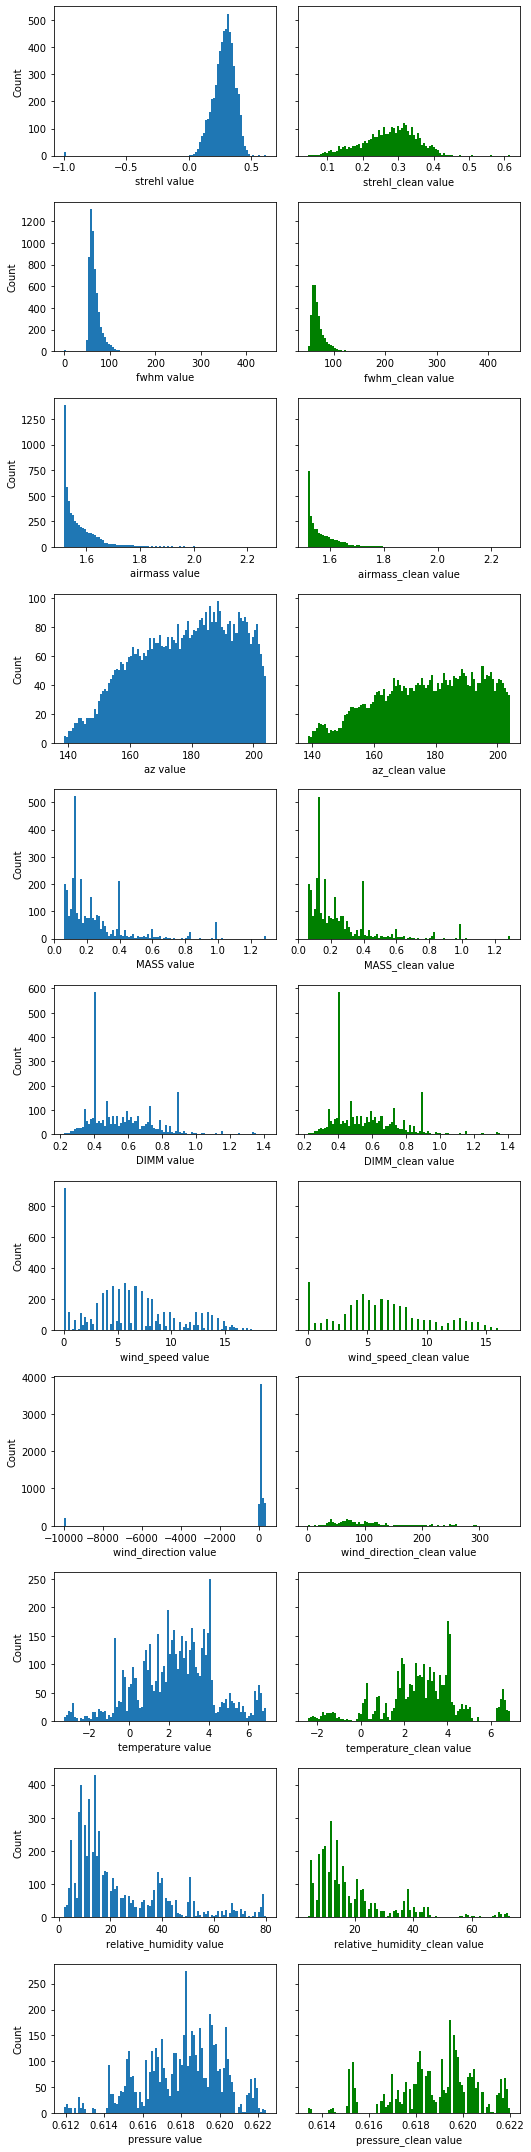

In [121]:
### Read info from Steve's metadata files
meta_data = Table.read(meta_file)
meta_data = meta_data.to_pandas() # convert to pandas
print(meta_data.shape)

# extract relevant data
meta_data = meta_data[use_cols]
# clean data
meta_clean = util.clean(meta_data)
print(meta_clean.shape)

### Graph the features to see what values they take on
bins = 100
fig, ax = plt.subplots(len(use_cols), 2, sharey='row', figsize=(7.5, 30))
for i, col in enumerate(use_cols):
    ax[i,0].hist(meta_data[col], bins)
    #ax[i,0].set_title(col)
    ax[i,0].set_xlabel(col+" value")
    ax[i,0].set_ylabel("Count")
    
    ax[i,1].hist(meta_clean[col], bins, color='g')
    ax[i,1].set_xlabel(col+"_clean value")
    #ax[i,1].set_title(col+" clean")

plt.tight_layout()
plt.savefig("plots/feature_histograms.png")

In [4]:
# Extract y variables
Y = meta_clean[use_cols[:2]]
strehl = meta_clean['strehl']
fwhm = meta_clean['fwhm']

# Extract x variables
X = meta_clean[use_cols[2:]]

In [5]:
### Scale the data
# StandardScaler() subtracts the mean and divides by the standard deviation
# Very important for PCA to normalize for high-magnitude features
X_scaled = StandardScaler().fit_transform(X)
# (1-tolerance) is the amount (%) of variation we keep in our data
tolerance = 0.01

In [88]:
### Basic PCA - extracts features which have the most variation in the data
pca = PCA(1-tolerance)
#pca = PCA(n_components=3)
pca.fit(X_scaled)
# View variance ratios
list(np.round(pca.explained_variance_ratio_, 2))
# 1. If the emphasis is on knowing what our features mean then this is not a great algorithm to use
# 2. We have so few features that we probably don't need to eliminate any if we use them as-is
# 3. The explained variance ratios are also all fairly small, so PCA isn't likely to help a lot

[0.25, 0.21, 0.17, 0.12, 0.08, 0.07, 0.05, 0.04, 0.01]

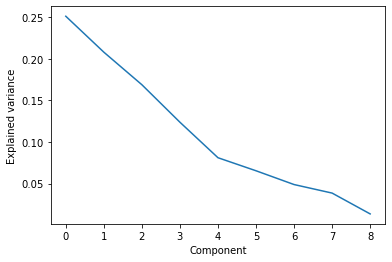

In [122]:
### Plot eigenvalues
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Explained variance")
plt.savefig("plots/pca_expl_var.png")

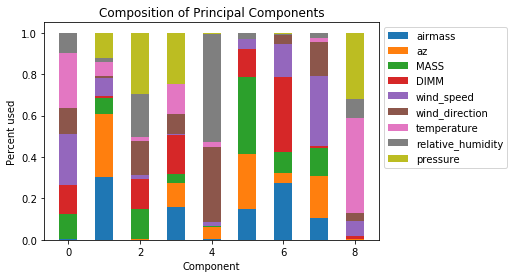

In [123]:
### Plot makeup of principal components
x = np.arange(0, pca.n_components_)
colors = plt.cm.get_cmap('viridis', pca.n_components_)

prev_bar = np.zeros(pca.n_components_)
for i, component in enumerate(pca.components_.T):
    c = component**2
    plt.bar(x, c, width=0.5, bottom=prev_bar, label=use_cols[2:][i])
    prev_bar += c

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Component")
plt.ylabel("Percent used")
plt.title("Composition of Principal Components")
plt.savefig("plots/pca_composition.png")

In [18]:
### Testing Random Forest Regressor
# This does not rely on feature scale, so we will leave it out
# This is basically identical to Kaggle's Intro ML exercise - just a proof of concept

# Set up parameters and data sets
percent_errors = {}

params = {"n_estimators":[1, 500], "max_depth": [1, 1000], "max_features":[1, len(X.columns)]}
for col in Y.columns:
    # train-test split
    train_X, val_X, train_y, val_y = train_test_split(X, y)

    # Initialize Random Forest Regressor
    rf = RandomForestRegressor()
    search = GridSearchCV(rf, params, cv=5, scoring="neg_mean_absolute_error")
    best = search.fit(train_X, train_y)
    train_pred = best.predict(train_X)
    test_pred = best.predict(val_X)
    
    # Calculate errors
    train_err = (train_pred-train_y)/train_y
    test_err = (test_pred-val_y)/val_y
    train_mape = np.mean(np.abs(train_err))
    test_mape = np.mean(np.abs(test_err))
    
    percent_errors[col] = test_err

    print(col, "training error:", train_mape, "\nTest error:", test_mape)

strehl training error: 0.044569927924962824 
Test error: 0.1209383523327309
fwhm training error: 0.044560357483082035 
Test error: 0.13216036254480648


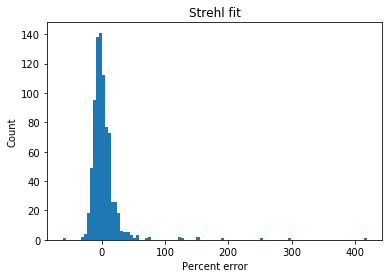

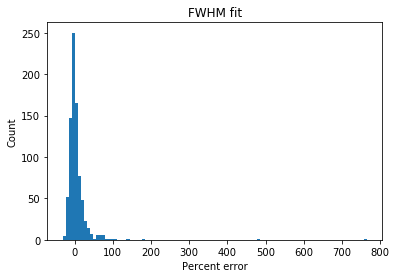

In [19]:
### Plots
# Strehl
plt.hist(100*percent_errors['strehl'], bins=100)
plt.title("Strehl fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("strehl_naive_rf_err.png")
plt.show()

# FWHM
plt.hist(100*percent_errors['fwhm'], bins=100)
plt.title("FWHM fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("fwhm_naive_rf_err.png")
plt.show()